# **Modelling**
## Healthcare Provider Fraud Detection - **Part 7**

In this seventh segment of my claim fraud analysis, I train and test models using a variety of learning methods and samples. To tidily hypertune and track so many models, I define a function to automate much of that process.

The main areas of this section might include:
- [Hypertuning and logging training results (function definition)](#hypertuning-method)
- [Training results visualization and discussion](#viz-discuss-training)

- [Evaluating and logging test results (function definition)](#testing-method)
- [Test results visualization and discussion](#viz-discuss-testing)

<br></br>

### **Approach**

A primary objective of this analysis is to explore and test recommendations from the literature I consulted. One such recommendation was to use ensemble learning methods for claim fraud classification, as those methods might here be especially suitable.

To test this in my modelling, I will use three such ensemble methods alongside two non-ensemble ones. Specifically, I will use the following techniques to fit gridsearches on each of my four samples:
1. Random Forest
2. Gradient Boosting
3. Ada Boosting
4. Naive Bayes
5. SVM

These combinations of learning method and sample thus total to twenty hypertunings. (5 methods * 4 samples.) To execute this hypertuning iteratively, I define a function to handle each run. The function produces both a fitted `gridsearchCV` object and a record of validation results, suitable for entry into a table that I also define below.

Once training validation is thusly completed for all of the methods and samples, I will conduct test validation in a similar fashion.

### **Quick Setup**



**Importing libraries**

In [1]:
import pandas as pd
import numpy as np

import pickle

import time
from datetime import datetime

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, make_scorer

import matplotlib.pyplot as plt
import seaborn as sns

**Loading objects from the preceding part**

In [2]:
# Mounting my Google Drive, where I've saved the preceding part's objects to file:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Loading the objects necessary for this part:

# Project directory path in Google Drive
project_dir_path = '/content/gdrive/MyDrive/fraud_data_dsc540/'

data_dir_filepath = project_dir_path + '/walkthrough/data/preprocessed/pkl/samples/'

# Load the datasets for each of the three samples:
X_train_cs = pd.read_pickle(f'{data_dir_filepath}cs/X_train_cs.pkl')
y_train_cs = pd.read_pickle(f'{data_dir_filepath}cs/y_train_cs.pkl')
X_test_cs = pd.read_pickle(f'{data_dir_filepath}cs/X_test_cs.pkl')
y_test_cs = pd.read_pickle(f'{data_dir_filepath}cs/y_test_cs.pkl')

X_train_cs_cfs = pd.read_pickle(f'{data_dir_filepath}cs_cfs/X_train_cs_cfs.pkl')
y_train_cs_cfs = pd.read_pickle(f'{data_dir_filepath}cs_cfs/y_train_cs_cfs.pkl')
X_test_cs_cfs = pd.read_pickle(f'{data_dir_filepath}cs_cfs/X_test_cs_cfs.pkl')
y_test_cs_cfs = pd.read_pickle(f'{data_dir_filepath}cs_cfs/y_test_cs_cfs.pkl')

X_train_os = pd.read_pickle(f'{data_dir_filepath}os/X_train_os.pkl')
y_train_os = pd.read_pickle(f'{data_dir_filepath}os/y_train_os.pkl')
X_test_os = pd.read_pickle(f'{data_dir_filepath}os/X_test_os.pkl')
y_test_os = pd.read_pickle(f'{data_dir_filepath}os/y_test_os.pkl')

X_train_os_cfs = pd.read_pickle(f'{data_dir_filepath}os_cfs/X_train_os_cfs.pkl')
y_train_os_cfs = pd.read_pickle(f'{data_dir_filepath}os_cfs/y_train_os_cfs.pkl')
X_test_os_cfs = pd.read_pickle(f'{data_dir_filepath}os_cfs/X_test_os_cfs.pkl')
y_test_os_cfs = pd.read_pickle(f'{data_dir_filepath}os_cfs/y_test_os_cfs.pkl')


# Load 'rand_st' , the random seed integer, from part #4, where it was declared:
part4_filepath = project_dir_path + '/walkthrough/part_4/'

with open(f'{part4_filepath}rand_st.pkl', 'rb') as file:
  rand_st = pickle.load(file)

### **Training**

As I mention above, I am running twenty gridsearches to arrive at as many trained models. In my experience, when training so many models in a notebook, it can be challenging to maintain consistency and organization throughout.

To mitigate those challenges, I find it helpful to automate both the processing and the result-logging as much as is reasonably possible.

#### **Setup**

##### **Table for training validation results**

I store the training validation record output in the following dataframe:

In [4]:
# Empty dataframe to store the training validation results.
train_results_df = pd.DataFrame({'ML Method':[],
                               'Class Balance':[],
                               'Sampling Technique':[],
                               'Feature Selection':[],
                                   'Hypertuning Runtime':[],
                                   'Training Precision':[],
                                   'Training Accuracy':[],
                                   'Training Recall':[],
                                   'Training F1':[],
                                   'Estimators':[],
                                   'Criterion':[],
                                   'Loss':[],
                                   'Max Depth':[],
                                   'Min Samples Split':[],
                                   'Learning Rate':[]
                                   })
train_results_df.T

""
ML Method
Class Balance
Sampling Technique
Feature Selection
Hypertuning Runtime
Training Precision
Training Accuracy
Training Recall
Training F1
Estimators


##### **Parameter Grids**

I will use the following parameter grids for each learning method's hypertuning, regardless of sample:

In [5]:
# Random Forest parameter grid
rf_param_grid = {
    # 'n_estimators': [50],
    'n_estimators': [150, 400],
    'criterion': ['entropy', 'gini'],
    'max_depth': [3, 7],
}

# Gradient Boosting parameter grid
gb_param_grid = {
    # 'n_estimators': [50],
    'n_estimators': [150, 400],
    'max_depth': [3, 7],
    'learning_rate': [1, 0.1]
}

# Ada Boosting parameter grid
ab_param_grid = {
    # 'n_estimators': [50],
    'n_estimators': [150, 400],
    'learning_rate': [1, 0.1]
}

# Naive Bayes parameter grid
nb_param_grid = {
    'var_smoothing': np.logspace(-8, -10, num=3)
}

# SVM parameter grid
svm_param_grid = {
    'C': [1.0, 0.1, 0.01],
    'kernel': ['rbf']
    }

##### **Dictionary for `gridsearchCV` objects**

Because some of the hypertuning runs of this work take a long time to process, I store the fitted `gridsearchCV` objects in a dictionary that is eventually saved to file.

In [6]:
gs_dict = {}

# Setting an indicator that the gridsearches should be reran. (If they should
# instead be loaded from file, run the next cell as well.)
run_the_gridsearches = True

###### **(Optional) Load previously-fitted gridsearchCV objects from file**

To instead load such a dictionary of fitted gridsearches from a previous run:

In [7]:
# run_the_gridsearches = False

# dict_filepath = '/content/gdrive/MyDrive/fraud_data_dsc540/modelling_results/' + \
#                 'gridsearch_dicts/gridsearch_dict__2024-11-12__22:20.pkl'

# with open(dict_filepath, 'rb') as file:
#   gs_dict = pickle.load(file)

<a name="hypertuning-method"></a>
##### **Function Definition:**



Next, I define the function that conducts the hypertuning of my twenty method-and-sample combinations.

I have coded the function to recognize the specified method and sample from a single string parameter. The function parses this string to determine the appropriate combination of method and sample, then commences hypertuning accordingly.

Before defining the function, I construct a list of its accepted specification strings:

In [8]:
ml_method_abbrs = ['rf', 'gb', 'ab', 'nb', 'svm']
sample_abbrs = ['cs', 'cs_cfs', 'os', 'os_cfs']
all_ml_s_combos = [ml + '_' + s for s in sample_abbrs for ml in ml_method_abbrs]
all_ml_s_combos

['rf_cs',
 'gb_cs',
 'ab_cs',
 'nb_cs',
 'svm_cs',
 'rf_cs_cfs',
 'gb_cs_cfs',
 'ab_cs_cfs',
 'nb_cs_cfs',
 'svm_cs_cfs',
 'rf_os',
 'gb_os',
 'ab_os',
 'nb_os',
 'svm_os',
 'rf_os_cfs',
 'gb_os_cfs',
 'ab_os_cfs',
 'nb_os_cfs',
 'svm_os_cfs']

Given one such string indicating the learning method and sample, my function conducts the hypertuning accordingly and then returns two objects:

1. the fitted `gridsearchCV` object, and
2. a `list` to be added as a record to my `train_val_results` dataframe defined at the top of this *Setup* section. This record represents the best result of the hypertuning for the given learning method, sample dataset, and parameter grid.

<br></br>
Because this function references the samples' datasets as they are assigned outside of its own scope, it can train models on such a dataset without taking it as a parameter. (Such referenced datasets include `X_train_cs`, `y_train_cs`, `X_train_os`, etc.) This can be a dubious design choice, and as such is important to note.

###### ***hypertune_w_named_clf_and_sample()***

In [9]:
def hypertune_w_named_clf_and_sample(ml_and_sample_string, verbose=1, prefitted_gs=None):
  """Given a string indicating the learning method and sample, return a fitted
  gridsearch as well as a list containing data on the training validation.

  If a pre-fitted gridsearchCV object is supplied, then no fitting is done, but
  a list of its training validation will still be returned, as retrieved from
  the gridsearchCV object's attributes. (This alternative to fitting a fresh
  gridsearch was coded so that a training validation record could be
  reconstructed without rerunning a lengthy hypertuning.)"""


  ## IDENTIFY SAMPLE AND ML METHOD FROM GIVEN STRING
  clf_type_abbr, sample_abbr = ml_and_sample_string.split('_', 1)


  ## BASED ON SAMPLE, SELECT DATASETS AND NOTE SAMPLE CHARACTERISTICS

  # Choose the training datasets that correspond to the sample abbreviation
  X_train_set, y_train_set = None, None
  sample_technique, feat_select_status = None, None
  match sample_abbr:
    case 'cs':
      X_train_set = X_train_cs
      y_train_set = y_train_cs
      sample_technique = 'Conventional'
      feat_select_status = 'None'
    case 'cs_cfs':
      X_train_set = X_train_cs_cfs
      y_train_set = y_train_cs_cfs
      sample_technique = 'Conventional'
      feat_select_status = 'CFS'
    case 'os':
      X_train_set = X_train_os
      y_train_set = y_train_os
      sample_technique = 'Oversampling'
      feat_select_status = 'None'
    case 'os_cfs':
      X_train_set = X_train_os_cfs
      y_train_set = y_train_os_cfs
      sample_technique = 'Oversampling'
      feat_select_status = 'CFS'
    case _:
      raise Exception(f'ERROR: Sample not identified by abbreviation: "{sample_abbr}"')

  # Determine the class balance of this sample
  class_cnts = y_train_set.value_counts()
  total_cnt = y_train_set.shape[0]

  unfraud_proportion = class_cnts.loc[0] / total_cnt
  potentialfraud_proportion = class_cnts.loc[1] / total_cnt

  unfraud_ratio_segment = int(round(unfraud_proportion, 2) * 100)
  potentialfraud_ratio_segment = int(round(potentialfraud_proportion, 2) * 100)

  class_balance = f'{unfraud_ratio_segment}-{potentialfraud_ratio_segment}'


  ## BASED ON ML METHOD, INSTANTIATE CLASSIFIER AND SELECT PARAM_GRID

  # Determine classifier type and instantiate the corresponding clf object.
  clf_type, clf, param_grid = None, None, None
  if clf_type_abbr == 'rf':
    clf_type = 'Random Forest'
    clf = RandomForestClassifier(random_state=rand_st)
    param_grid = rf_param_grid
  elif clf_type_abbr == 'gb':
    clf_type = 'Gradient Boosting'
    clf = GradientBoostingClassifier(random_state=rand_st)
    param_grid = gb_param_grid
  elif clf_type_abbr == 'ab':
    clf_type = 'Ada Boosting'
    clf = AdaBoostClassifier(random_state=rand_st)
    param_grid = ab_param_grid
  elif clf_type_abbr == 'nb':
    clf_type = 'Naive Bayes'
    clf = GaussianNB()
    param_grid = nb_param_grid
  elif clf_type_abbr == 'svm':
    clf_type = 'SVM'
    clf = SVC()
    param_grid = svm_param_grid
  else:
    raise Exception(f'ERROR: Classifier not identified by abbreviation: "{clf_type_abbr}"')


  ## RUN A GRIDSEARCH, OR LOAD A PREVIOUS ONE

  # Get a fitted gridsearchCV object, either by freshly running one or by
  # loading a pre-fitted one.
  gs = None
  if not prefitted_gs:
    # Run a fresh gridsearch/hypertuning

    precision_scorer = make_scorer(precision_score, zero_division=0)
    scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc',
            'precision': precision_scorer, 'recall': 'recall', 'f1': 'f1'}

    gs = GridSearchCV(estimator=clf, param_grid=param_grid,
                        cv=5,
                        scoring=scorers,
                        refit='precision',
                        verbose=verbose)

    feat_sel_status_print = '' if feat_select_status=='None' else ' + ' + feat_select_status
    sample_and_feat_sel_str = sample_technique + feat_sel_status_print
    print(f'HYPERTUNING: A {clf_type} classifier on the "{sample_and_feat_sel_str}" sample')

    gs.fit(X_train_set, y_train_set)

    print('COMPLETE.', end=' ')

  else:
    # Load a previous gridsearch (if one has been passed to the function as
    # optional parameter 'prefitted_gs')
    gs = prefitted_gs[ml_and_sample_string]


  ## RETRIEVE AND RECORD METRICS FROM THE GRIDSEARCH

  # Calculate the approximate time length of the hypertuning, using the
  # gridsearch's 'mean fit time' and 'mean score time' results.
  mean_fit_time = gs.cv_results_['mean_fit_time']
  mean_score_time = gs.cv_results_['mean_score_time']
  n_splits = gs.n_splits_
  n_iter = pd.DataFrame(gs.cv_results_).shape[0]

  hypertune_runtime = np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter
  print(f'Estimated runtime of this hypertuning: {round(hypertune_runtime, 2)} seconds',
        end='\n\n')

  # Log performance metrics from the gridsearch results, in a partial record
  # 'train_val_result_record'. (This and other partial records will be combined
  # to form the complete val. result record.
  gs_results = gs.cv_results_
  best_estimator_ind = np.where(gs_results['rank_test_precision'] == 1)[0][0]
  train_val_result_record = [hypertune_runtime]
  for metric in ['mean_test_precision', 'mean_test_Accuracy', 'mean_test_recall', 'mean_test_f1']:
    train_val_result_record.append(round(gs_results[metric][best_estimator_ind], 4))


  # Create 'ML method and sample details' segment of the val. result record.
  method_name_and_sample_data = [clf_type, class_balance, sample_technique,
                                 feat_select_status]


  # Create 'best parameters' segment of the train_results_df record.

  if clf_type not in ['Random Forest', 'Gradient Boosting', 'Ada Boosting']:
    param_record = ['N/A'] * 6
  else:
    hps = gs.best_estimator_.get_params()
    param_record = [hps['n_estimators'], 'N/A', 'N/A', 1, 2, 'N/A']
    if 'criterion' in hps:
      param_record[1] = hps['criterion']
    if 'loss' in hps:
      param_record[2] = hps['loss'].replace('_', ' ').title()
    elif clf_type == 'Ada Boosting':
      param_record[2] = 'Exponential Loss'
    if 'max_depth' in hps:
      param_record[3] = hps['max_depth']
    if 'min_samples_split' in hps:
      param_record[4] = hps['min_samples_split']
    if 'learning_rate' in hps:
      param_record[5] = hps['learning_rate']


  # Assemble the complete train_results_df record from the segments.
  record = method_name_and_sample_data + train_val_result_record + param_record

  # Return both the gridsearch and the record (a list.)
  return gs, record

#### **Execution**

As I explained before just now defining the function, it is passed strings to indicate the desired learning method and sample for training.

I here reprint the list of those strings for reference, then proceed to the iterative hypertuning:

In [10]:
# ml_method_abbrs = ['rf', 'gb', 'ab', 'nb', 'svm']
# sample_abbrs = ['cs', 'cs_cfs', 'os', 'os_cfs']
# all_ml_s_combos = [ml + '_' + s for s in sample_abbrs for ml in ml_method_abbrs]
all_ml_s_combos

['rf_cs',
 'gb_cs',
 'ab_cs',
 'nb_cs',
 'svm_cs',
 'rf_cs_cfs',
 'gb_cs_cfs',
 'ab_cs_cfs',
 'nb_cs_cfs',
 'svm_cs_cfs',
 'rf_os',
 'gb_os',
 'ab_os',
 'nb_os',
 'svm_os',
 'rf_os_cfs',
 'gb_os_cfs',
 'ab_os_cfs',
 'nb_os_cfs',
 'svm_os_cfs']

By passing these permutated specification strings to my hypertuning function, I iteratively run gridsearches for all those combinations of ML method and sample. At the time of writing, it takes ~20 minutes to complete these twenty hypertunings:

In [11]:
# Noting the start time of this process in a string, to later append to the
# filename of the saved results.
timestamp_of_run = datetime.now().strftime("__%Y-%m-%d__%H:%M")

# Iteratively running gridsearches, saving them and a record of their results
# each time.
for index, combo in enumerate(all_ml_s_combos):
  gs_dict[combo], train_results_df.loc[index+1] = hypertune_w_named_clf_and_sample(combo, verbose=1)
  # print(train_results_df[:index+1])


HYPERTUNING: A Random Forest classifier on the "Conventional" sample
Fitting 5 folds for each of 8 candidates, totalling 40 fits
COMPLETE. Estimated runtime of this hypertuning: 87.34 seconds

HYPERTUNING: A Gradient Boosting classifier on the "Conventional" sample
Fitting 5 folds for each of 8 candidates, totalling 40 fits
COMPLETE. Estimated runtime of this hypertuning: 388.38 seconds

HYPERTUNING: A Ada Boosting classifier on the "Conventional" sample
Fitting 5 folds for each of 4 candidates, totalling 20 fits
COMPLETE. Estimated runtime of this hypertuning: 62.08 seconds

HYPERTUNING: A Naive Bayes classifier on the "Conventional" sample
Fitting 5 folds for each of 3 candidates, totalling 15 fits
COMPLETE. Estimated runtime of this hypertuning: 0.36 seconds

HYPERTUNING: A SVM classifier on the "Conventional" sample
Fitting 5 folds for each of 3 candidates, totalling 15 fits
COMPLETE. Estimated runtime of this hypertuning: 3.49 seconds

HYPERTUNING: A Random Forest classifier on th

With the training and hypertuning of the models now complete, I review their performances. I first do so by examining the table where I've logged them, `train_results_df`.

It is ordered as the runs were, by sample and then by learning method:

In [12]:
train_results_df

,ML Method,Class Balance,Sampling Technique,Feature Selection,Hypertuning Runtime,Training Precision,Training Accuracy,Training Recall,Training F1,Estimators,Criterion,Loss,Max Depth,Min Samples Split,Learning Rate
1,Random Forest,91-9,Conventional,None,87.343294,0.9455,0.9150,0.0988,0.1774,400,entropy,N/A,3,2,N/A
2,Gradient Boosting,91-9,Conventional,None,388.377201,0.6874,0.9300,0.4642,0.5525,150,friedman_mse,Log Loss,3,2,0.1
3,Ada Boosting,91-9,Conventional,None,62.075286,0.8338,0.9328,0.3531,0.4955,400,N/A,Exponential Loss,1,2,0.1
4,Naive Bayes,91-9,Conventional,None,0.364388,0.5690,0.9191,0.5778,0.5729,N/A,N/A,N/A,N/A,N/A,N/A
5,SVM,91-9,Conventional,None,3.488749,0.7465,0.9295,0.3753,0.4992,N/A,N/A,N/A,N/A,N/A,N/A
6,Random Forest,91-9,Conventional,CFS,41.113428,0.8076,0.9337,0.3852,0.5207,400,entropy,N/A,3,2,N/A
7,Gradient Boosting,91-9,Conventional,CFS,69.031518,0.6698,0.9275,0.4519,0.5382,150,friedman_mse,Log Loss,3,2,0.1
8,Ada Boosting,91-9,Conventional,CFS,20.080298,0.8318,0.9314,0.3358,0.4777,400,N/A,Exponential Loss,1,2,0.1
9,Naive Bayes,91-9,Conventional,CFS,0.347420,0.6818,0.9321,0.5160,0.5873,N/A,N/A,N/A,N/A,N/A,N/A
10,SVM,91-9,Conventional,CFS,2.646816,0.7450,0.9291,0.3728,0.4960,N/A,N/A,N/A,N/A,N/A,N/A


I am primarily interested in the precision of these models. To better highlight the top performers therein, I order the table by that metric in another viewing:

In [13]:
train_results_df.sort_values(by='Training Precision', ascending=False)

,ML Method,Class Balance,Sampling Technique,Feature Selection,Hypertuning Runtime,Training Precision,Training Accuracy,Training Recall,Training F1,Estimators,Criterion,Loss,Max Depth,Min Samples Split,Learning Rate
1,Random Forest,91-9,Conventional,None,87.343294,0.9455,0.9150,0.0988,0.1774,400,entropy,N/A,3,2,N/A
12,Gradient Boosting,75-25,Oversampling,None,400.992220,0.9102,0.9694,0.9739,0.9406,400,friedman_mse,Log Loss,7,2,0.1
19,Naive Bayes,75-25,Oversampling,CFS,0.236792,0.8616,0.8654,0.5501,0.6710,N/A,N/A,N/A,N/A,N/A,N/A
17,Gradient Boosting,75-25,Oversampling,CFS,78.256970,0.8542,0.9507,0.9678,0.9072,150,friedman_mse,Log Loss,7,2,1
15,SVM,75-25,Oversampling,None,6.985196,0.8496,0.8660,0.5639,0.6775,N/A,N/A,N/A,N/A,N/A,N/A
20,SVM,75-25,Oversampling,CFS,7.118154,0.8484,0.8673,0.5716,0.6826,N/A,N/A,N/A,N/A,N/A,N/A
3,Ada Boosting,91-9,Conventional,None,62.075286,0.8338,0.9328,0.3531,0.4955,400,N/A,Exponential Loss,1,2,0.1
8,Ada Boosting,91-9,Conventional,CFS,20.080298,0.8318,0.9314,0.3358,0.4777,400,N/A,Exponential Loss,1,2,0.1
11,Random Forest,75-25,Oversampling,None,98.293560,0.8113,0.9140,0.8554,0.8324,150,gini,N/A,7,2,N/A
6,Random Forest,91-9,Conventional,CFS,41.113428,0.8076,0.9337,0.3852,0.5207,400,entropy,N/A,3,2,N/A


<a name="viz-discuss-training"></a>
#### **Visualizing the training results**
To compare the models' precision yet more clearly, I visualize them in a grouped barchart:

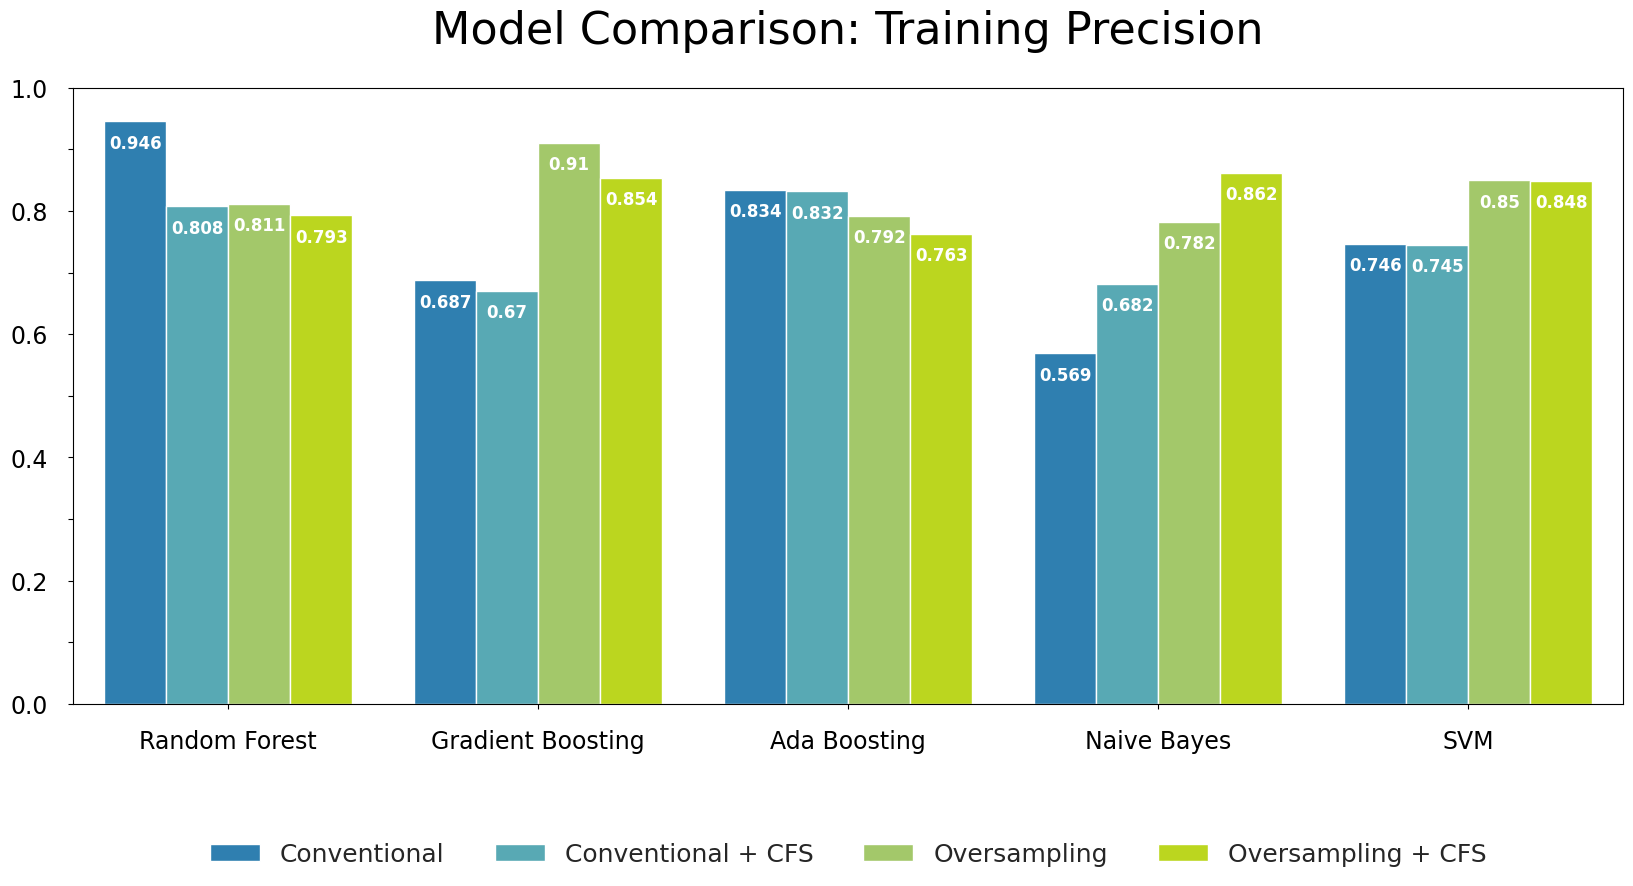

In [14]:
train_results_df['Sample Combo'] = train_results_df.apply(lambda row: row['Sampling Technique']
                                                        + ' + ' + row['Feature Selection']
                                                        if row['Feature Selection'] != 'None'
                                                        else row['Sampling Technique'],
                                                        axis=1)

fig, ax = plt.subplots(figsize=(20, 8))

custom_palette = {'Conventional': '#1984c5', 'Conventional + CFS': '#48b5c4',
                  'Oversampling': '#a6d75b', 'Oversampling + CFS': '#d0f400'}


sns.set_theme(style='whitegrid')
ax = sns.barplot(data=train_results_df,
            x='ML Method',
            y='Training Precision',
            hue='Sample Combo',
            palette=custom_palette)

# ax.get_xaxis().set_visible(False)
ax.set_title('Model Comparison: Training Precision', fontsize=32, pad=32)
ax.tick_params(axis='both', labelsize=17, pad=15)
ax.set_xlabel("")
# ax.set_ylabel("Precision", fontsize=20, labelpad=25)
ax.set_ylabel("")

ax.legend()
sns.move_legend(ax, "lower center", fontsize= 18,
                bbox_to_anchor=(0.5, -0.3), ncol=4, frameon=False)

for bar in ax.patches:
  height = bar.get_height()
  ax.text(bar.get_x() + bar.get_width() / 2, height - 0.035, round(height, 3),
          ha='center', va='center', color='white', fontweight='semibold')

plt.yticks(np.linspace(0, 1, 11))
for label in ax.yaxis.get_ticklabels()[1::2]:
  label.set_visible(False)

plt.show()

#### **Discussing the results**



##### **The top performers in precision**
    
  - **A Random Forest is the top performer in precision:** Such a classifier trained on the conventional sample achieved the highest such score, `0.946`. In that regard, it substantially leads by ~`0.04` the next-best score, that `0.908` achieved by a Gradient Boosting model trained on the rebalanced & unreduced ('os') sample.

  - **Gradient Boosting is the next-most precise, and outclasses the RF in other respects:** Though its precision might be substantially inferior to that of the optimal Random Forest, the Gradient Boosting classifier from the 'oversampled and not CFS-reduced' sample has other merits worth considering. It far outmatches all the other models in this table's remaining performance metrics: accuracy, recall, and F1. In fact, the Gradient Boosting models appear to have all excelled in these metrics.

  - **The other ML methods' top models scored `0.04` less in precision or worse, compared to the Gradient Boosting one at second banana.** The scores of the best models from the Ada Boosting, Naive Bayes, and SVM models neighbored each other by roughly `0.01`.

##### **Other takeaways**


  - **The Naive Bayes method yielded both the least precise model and the third-most.** The former was trained on the conventional sample, while the latter was trained on the sample that was both rebalanced (through oversampling) and reduced through correlation-based feature selection.
    - **Also, these NB models fared better on the feature-selected samples than on the unreduced counterparts.** This goes counter to my expectations, as I imagine feature selection as typically removing information and, in turn, removing predictive power.

  - **No sample appears to be the clear front-runner:** There isn't one sample that is clearly favored by most models, nor is there a clearly disfavorable one.

    - **Oversampling was a mixed bag:** It led to worse models for Random Forest or Ada Boosting, but much better ones for Gradient Boosting, Naive Bayes, and SVM.

This training has yielded some interesting results. Having discussed them in some detail, I now move on to test validation.

#### **Saving results to file**

In [15]:
# Save gridsearch dict and training result df to files (if the gridsearches
# were indeed ran, rather than loaded from file.)
if run_the_gridsearches:
  # Save dictionary of gridsearches to pickle file
  path_to_data_dir = project_dir_path + '/walkthrough/modelling_results/gridsearch_dicts/'
  !mkdir -p {path_to_data_dir}

  with open(f'{path_to_data_dir}gridsearch_dict{timestamp_of_run}.pkl', 'wb') as file:
    pickle.dump(gs_dict, file)

  # Save table of training results to pickle file
  path_to_data_dir = project_dir_path + '/walkthrough/modelling_results/train_results_dfs/pkl/'
  !mkdir -p {path_to_data_dir}
  train_results_df.to_pickle(f'{path_to_data_dir}train_results_df{timestamp_of_run}.pkl')

  # Save table of training results to csv file
  path_to_data_dir = project_dir_path + '/walkthrough/modelling_results/train_results_dfs/csv/'
  !mkdir -p {path_to_data_dir}
  train_results_df.to_csv(f'{path_to_data_dir}train_results_df{timestamp_of_run}.csv')

### **Testing**

#### **Setup**

##### **Table for testing validation results**

In [16]:
# Empty dataframe to store the test validation results. Ensemble methods are the
# focus of my modelling.
test_results_df = pd.DataFrame({'ML Method':[],
                               'Class Balance':[],
                               'Sampling Technique':[],
                               'Feature Selection':[],
                               'Test Precision':[],
                               'Test Accuracy':[],
                               'Test Recall':[],
                               'Test F1':[],
                               'Estimators':[],
                               'Criterion':[],
                               'Loss':[],
                               'Max Depth':[],
                               'Min Samples Split':[],
                               'Learning Rate':[]
                                  })
test_results_df.T

""
ML Method
Class Balance
Sampling Technique
Feature Selection
Test Precision
Test Accuracy
Test Recall
Test F1
Estimators
Criterion


<a name="testing-method"></a>
##### **Function definition:**

My function for evaluating the test performances of the models closely resembles that for the training. It too recognizes the subject of evaluation from a specification string, and outputs a record of a model's performance.

But this method for test differs slightly by taking a different parameter. It still takes a string specifying sample and method, but that's as part of a dictionary pair, one that also includes the fitted gridsearch object corresponding.

###### ***test_model_from_gs_dict_item()***

In [17]:
def test_model_from_gs_dict_item(gs_dict_item):
  """ Given an item from the gridsearch dictionary, run its model on the test
  data and return a record of its performance (for the test_results_df.)"""

  gs_name = gs_dict_item[0]
  gs = gs_dict_item[1]

  ## SELECT RELEVANT DATA AND NOTE CHARACTERISTICS OF SAMPLE AND MODEL

  # From the gridsearch's name, parse which sample it corresponds to.
  # (Rather than parsing for the ML method as well here, that information will
  # instead be retrieved later from the gridsearch object, itself.)
  _, sample_abbr = gs_name.split('_', 1)

  # According to training sample, select the relevant test sets of predictors
  # and labels.
  # Also, note some metadata of the training sample in a partial record.
  X_test_set, y_test_set, train_sample_info = None, None, None
  match sample_abbr:
    case 'cs':
      X_test_set = X_test_cs
      y_test_set = y_test_cs
      train_sample_info = ['91-9', 'Conventional', 'None']
    case 'cs_cfs':
      X_test_set = X_test_cs_cfs
      y_test_set = y_test_cs_cfs
      train_sample_info = ['91-9', 'Conventional', 'CFS']
    case 'os':
      X_test_set = X_test_os
      y_test_set = y_test_os
      train_sample_info = ['75-25', 'Oversampling', 'None']
    case 'os_cfs':
      X_test_set = X_test_os_cfs
      y_test_set = y_test_os_cfs
      train_sample_info = ['75-25', 'Oversampling', 'CFS']

  # Determine and note the ML method / classifier type from the gridsearch,
  # directly.
  ml_method = gs.get_params()['estimator']
  clf_type = ''
  if isinstance(ml_method, RandomForestClassifier):
    clf_type = 'Random Forest'
  elif isinstance(ml_method, GradientBoostingClassifier):
    clf_type = 'Gradient Boosting'
  elif isinstance(ml_method, AdaBoostClassifier):
    clf_type = 'Ada Boosting'
  elif isinstance(ml_method, GaussianNB):
    clf_type = 'Naive Bayes'
  elif isinstance(ml_method, SVC):
    clf_type = 'SVM'


  # Create partial record of the learning method and sample metadata
  lm_and_sample_record = [clf_type, *train_sample_info]


  # Retrieve model's parameters from the gridsearch and log them in
  # another segment of the record.
  if clf_type not in ['Random Forest', 'Gradient Boosting', 'Ada Boosting']:
    param_record = ['N/A'] * 6
  else:
    hps = gs.best_estimator_.get_params()
    param_record = [hps['n_estimators'], 'N/A', 'N/A', 1, 2, 'N/A']
    if 'criterion' in hps:
      param_record[1] = hps['criterion']
    if 'loss' in hps:
      param_record[2] = hps['loss'].replace('_', ' ').title()
    elif clf_type == 'Ada Boosting':
      param_record[2] = 'Exponential Loss'
    if 'max_depth' in hps:
      param_record[3] = hps['max_depth']
    if 'min_samples_split' in hps:
      param_record[4] = hps['min_samples_split']
    if 'learning_rate' in hps:
      param_record[5] = hps['learning_rate']


  ## RUN TEST VALIDATION OF THE MODEL
  test_preds = gs.predict(X_test_set)
  test_classif_dict = classification_report(test_preds, y_test_set,
                                            output_dict=True, zero_division=0)

  test_acc = test_classif_dict['accuracy']
  test_f1 = test_classif_dict['macro avg']['f1-score']
  test_precision = test_classif_dict['macro avg']['precision']
  test_recall = test_classif_dict['macro avg']['recall']

  # Log the test performance in a final segment of the test validation record.
  test_perf_record = [test_precision, test_acc, test_recall, test_f1]

  # Assemble from the segments a full record of the test validation results,
  # then return it.
  full_test_record = lm_and_sample_record + test_perf_record + param_record
  return full_test_record

#### **Execution**

In [18]:
for index, gs_dict_entry in enumerate(gs_dict.items()):
  test_results_df.loc[index+1] = test_model_from_gs_dict_item(gs_dict_entry)

In [19]:
test_results_df.sort_values(by='Test Precision', ascending=False)

,ML Method,Class Balance,Sampling Technique,Feature Selection,Test Precision,Test Accuracy,Test Recall,Test F1,Estimators,Criterion,Loss,Max Depth,Min Samples Split,Learning Rate
18,Ada Boosting,75-25,Oversampling,CFS,0.864000,0.898336,0.727220,0.771593,400,N/A,Exponential Loss,1,2,1
11,Random Forest,75-25,Oversampling,None,0.853519,0.919593,0.762414,0.798343,150,gini,N/A,7,2,N/A
13,Ada Boosting,75-25,Oversampling,None,0.848422,0.910351,0.744213,0.782921,400,N/A,Exponential Loss,1,2,1
16,Random Forest,75-25,Oversampling,CFS,0.847403,0.908503,0.740855,0.779953,150,gini,N/A,7,2,N/A
15,SVM,75-25,Oversampling,None,0.829715,0.940850,0.823973,0.826811,N/A,N/A,N/A,N/A,N/A,N/A
20,SVM,75-25,Oversampling,CFS,0.828696,0.939002,0.817468,0.822952,N/A,N/A,N/A,N/A,N/A,N/A
14,Naive Bayes,75-25,Oversampling,None,0.822287,0.911275,0.743616,0.775052,N/A,N/A,N/A,N/A,N/A,N/A
4,Naive Bayes,91-9,Conventional,None,0.814061,0.920518,0.763804,0.785871,N/A,N/A,N/A,N/A,N/A,N/A
19,Naive Bayes,75-25,Oversampling,CFS,0.812462,0.941774,0.833351,0.822464,N/A,N/A,N/A,N/A,N/A,N/A
12,Gradient Boosting,75-25,Oversampling,None,0.799649,0.942699,0.842973,0.819418,400,friedman_mse,Log Loss,7,2,0.1


<a name="viz-discuss-testing"></a>
#### **Visualizing the test results**

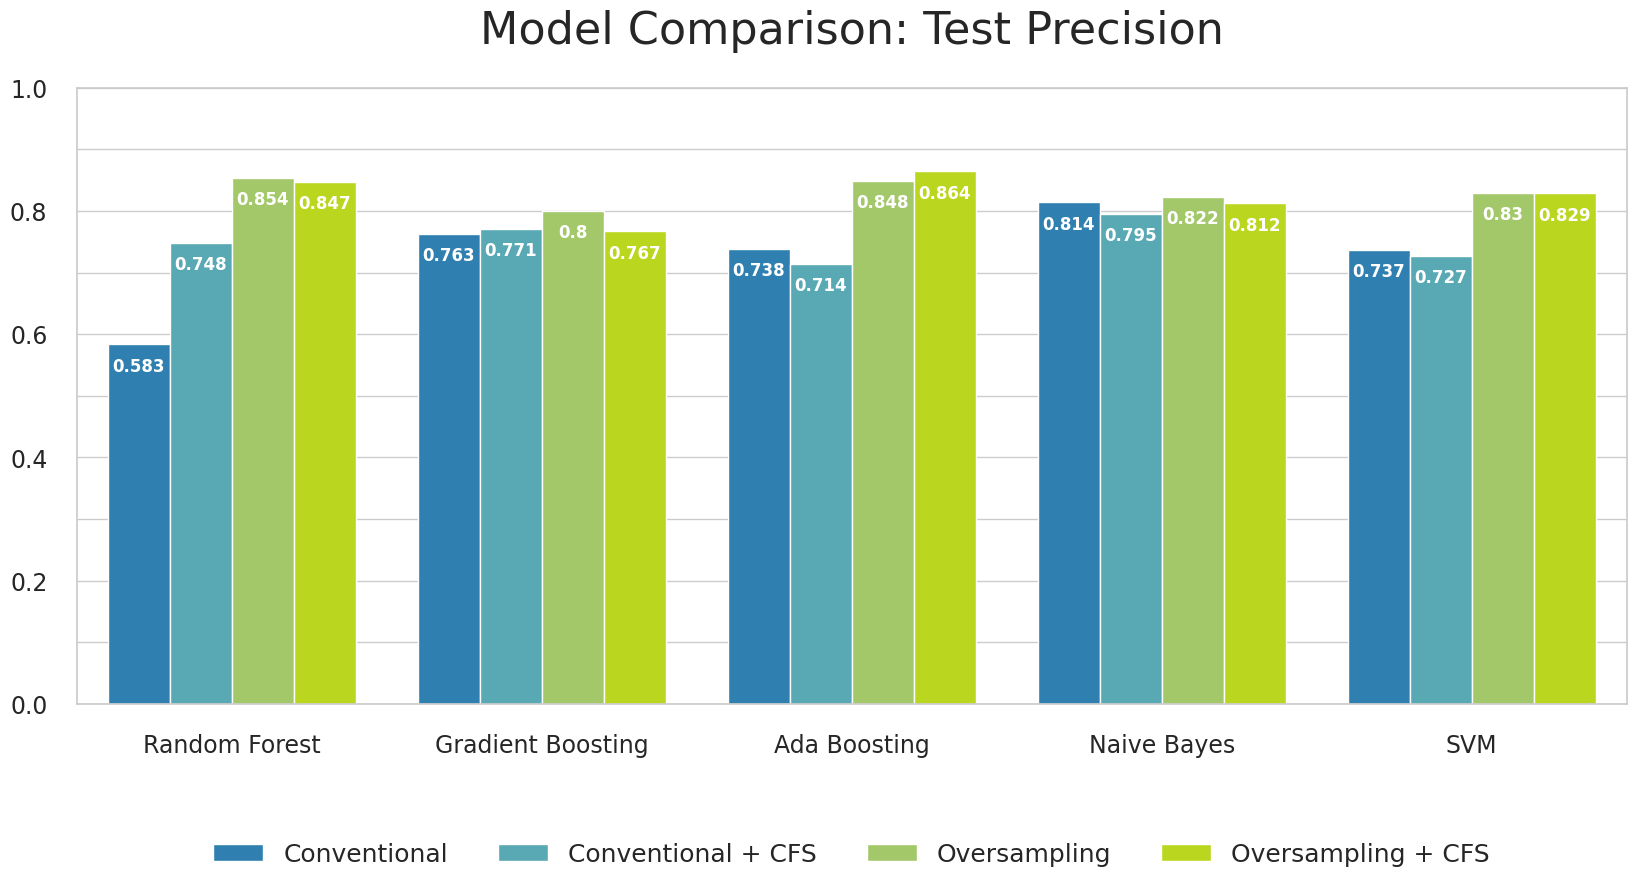

In [20]:
test_results_df['Sample Combo'] = test_results_df.apply(lambda row: row['Sampling Technique']
                                                        + ' + ' + row['Feature Selection']
                                                        if row['Feature Selection'] != 'None'
                                                        else row['Sampling Technique'],
                                                        axis=1)

fig, ax = plt.subplots(figsize=(20, 8))

custom_palette = {'Conventional': '#1984c5', 'Conventional + CFS': '#48b5c4',
                  'Oversampling': '#a6d75b', 'Oversampling + CFS': '#d0f400'}


sns.set_theme(style='whitegrid')
ax = sns.barplot(data=test_results_df,
            x='ML Method',
            y='Test Precision',
            hue='Sample Combo',
            palette=custom_palette)

# ax.get_xaxis().set_visible(False)
ax.set_title('Model Comparison: Test Precision', fontsize=32, pad=32)
ax.tick_params(axis='both', labelsize=17, pad=15)
ax.set_xlabel("")
# ax.set_ylabel("Precision", fontsize=20, labelpad=25)
ax.set_ylabel("")

ax.legend()
sns.move_legend(ax, "lower center", fontsize= 18,
                bbox_to_anchor=(0.5, -0.3), ncol=4, frameon=False)

for bar in ax.patches:
  height = bar.get_height()
  ax.text(bar.get_x() + bar.get_width() / 2, height - 0.035, round(height, 3),
          ha='center', va='center', color='white', fontweight='semibold')

plt.yticks(np.linspace(0, 1, 11))
for label in ax.yaxis.get_ticklabels()[1::2]:
  label.set_visible(False)

plt.show()

#### **Discussing the results**

##### **The top performers in precision**

- **The four most precise models came from Ada Boosting and Random Forest models trained on the oversampled datasets.** The next-highest precision scores came from the SVM and Naive Bayes methods.
  - **Gradient Boosting's best model scored only the tenth-highest precision** of the twenty models.

- **The top-performing combination of method and sample from training did the worst here in test,** namely the Random Forest trained on the conventional sample. This suggests that the model may have been severely overfitted.

##### **Other takeaways**

- **The oversampled datasets consistently trained the most precise model for each learning method.** In training, a couple methods rather yielded worse models when trained thereon.
  - The Gradient Boosting and Naive Bayes models scored the most similar precisions, within each method. I wonder if this suggests stability across these sampling differences.

- **Ensemble learning methods yielded the most precise methods, but perhaps by more narrow margin than I was expecting.** Their advantages might be even less remarkable to me considering their much lengthier training times, here.

- **Feature selection drastically reduced training times, without drastically costing the precision.** In one case, for Ada Boosting on the oversampled datasets, the model trained on the feature-selected data even performed better.

- **SVM now rivals Gradient Boosting in providing competitively precise models that also score well in accuracy, recall, and F1.**


Between this testing and the training, there were some stark reversals of observed patterns. These might affirm the unquestionable importance of test validation, as well as underscore the risks of overinterpreting the results of training, or lingering too long there.

#### **Saving results to file**

In [21]:
# Save the testing result df to file
if run_the_gridsearches:
  path_to_data_dir = project_dir_path + '/walkthrough/modelling_results/test_results_dfs/pkl/'
  !mkdir -p {path_to_data_dir}
  test_results_df.to_pickle(f'{path_to_data_dir}test_results_df{timestamp_of_run}.pkl')

  path_to_data_dir = project_dir_path + '/walkthrough/modelling_results/test_results_dfs/csv/'
  !mkdir -p {path_to_data_dir}
  test_results_df.to_csv(f'{path_to_data_dir}test_results_df{timestamp_of_run}.csv')